# Now for multiple reactions

In [14]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

## SSA Prep code:

In [121]:
# Create a stoichiometric matrix of 3 reactions, lets use module 1 from the paper

stoich_matrix_1 = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])

num_internal_species = 3

species_names = ["A", "B","C","D","E"]


# need to define stoichiometry for the reverse reaction

SM = []

for p in range(stoich_matrix_1.cols):
    SM.append(stoich_matrix_1[:, p])
    SM.append(-stoich_matrix_1[:, p])

SM_with_reverse_stoichiometry = Matrix.hstack(*SM)

SM_with_reverse_stoichiometry


# build a list of population counts:

current_pops = [20,20,20,50,50]

count_combos = []
current_pops_index = []
combination = []

# determine which species are in each reaction: RUN OUTSIDE OF LOOP

for l in range(SM_with_reverse_stoichiometry.cols): # repeat for all reactions

    reaction = SM_with_reverse_stoichiometry[:,l] # extract each reaction one by one

    current_reaction_indexes = []

    for p in range(len(reaction)): # go through each element in the reaction

        if reaction[p] == -1: # if a element is -1, that species is consumed in the reaction

            current_reaction_indexes.append(p) # store the index of the reaction (is the same as in the current_pops list)
    
    current_pops_index.append(current_reaction_indexes)
    
print(current_pops_index)

# build the propensity vector, put this into a function to be used in the loop of the SSA

rates_list = [0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01]

def calculate_propensity_function(SM_with_reverse_stoichiometry, current_pops, rates_list):
    
    propensity_vector = []

    for a in range(SM_with_reverse_stoichiometry.cols): # repeat for all reactions

        used_counts = []

        for index in current_pops_index[a]: # loop over each species used in this reaction
            
            used_counts.append(current_pops[index]) # create a list containing the actual current count values 

        propensity = np.prod(used_counts) * rates_list[a] # calculate the propensity for this reaction

        propensity_vector.append(propensity) # add to the propensity vector

    propensity_vector = np.array(propensity_vector) # vectorise for speed


    return propensity_vector



[[0, 3], [1], [1], [0, 4], [1, 3], [2]]


In [107]:
SM_with_reverse_stoichiometry

Matrix([
[-1,  1,  1, -1,  0,  0],
[ 1, -1, -1,  1, -1,  1],
[ 0,  0,  0,  0,  1, -1],
[-1,  1,  0,  0, -1,  1],
[ 0,  0,  1, -1,  0,  0]])

the reactions for the stoichiometric matrix above read like: (reversible)

A + D = B ,B = A + E, B + D = C

## SSA Simulation code

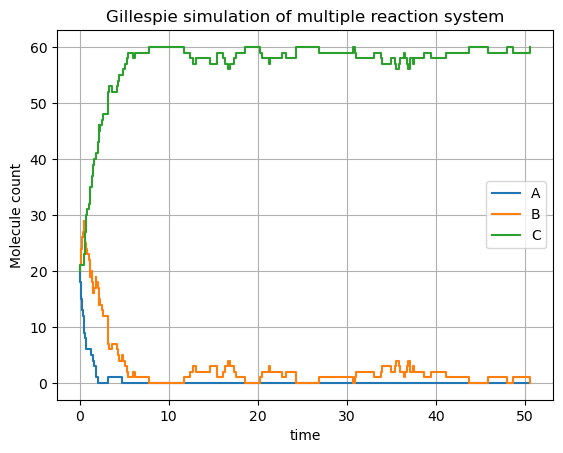

Final A: 0
Final B: 0
Final C: 60


In [ ]:
# initial conditions

current_pops = [20,20,20,50,50] # set initial pops, in order: same as SM, e.g. for mod 1 from 2025 [Ea, Eas, Eas2, S, Na] 

t, T = 0.0, 50.0 # initial and final time

times = [t]

counts_list = [[x] for x in current_pops] # in order: same as rows of SM

rates_list = [0.0105, 0.01, 0.0105, 0.01, 0.0105, 0.01] # in order: kf_1, kb_1, kf_2, ... , kf_n, kb_n

# algorithm:

while t < T:

    
    propensity_vector = calculate_propensity_function(SM_with_reverse_stoichiometry, current_pops, rates_list)
    
    a0 = np.sum(propensity_vector)

    if a0 == 0:
        break

    r1, r2 = np.random.rand(2) # draw two random numbers - how random are they, use qiskit for quanutm randomness?

    tau = -1*np.log(r1) / a0

    # Now need to select which reaction will occur using r2, prob is weighted by which is most likely to occur at the current state of the system:

    target_value = r2*a0

    cumulative = 0

    for n in range(len(propensity_vector)):

        cumulative += propensity_vector[n]

        if target_value <= cumulative:

            reaction_chosen = n

            break


    # perform updates

    t += tau

    stoich_vector = SM_with_reverse_stoichiometry[:,reaction_chosen] # selects the reaction we will perform


    # population change depending on stoichiometric vector

    for m in range(num_internal_species):

        current_pops[m] += stoich_vector[m] # ensure order of populations in list is same as rows in SM


    # update the counts

    times.append(t)

    for m in range(len(species_names)):
        
        counts_list[m].append(current_pops[m])

# Plot results

for m in range(num_internal_species):
        
    plt.step(times, counts_list[m], where="post", label=species_names[m])

plt.xlabel("time"); plt.ylabel("Molecule count")
plt.grid(True)
plt.title("Gillespie simulation of multiple reaction system")
plt.legend(); plt.show()


# print final counts

for m in range(num_internal_species):
        
    print(r'Final {}: {}'.format(species_names[m], counts_list[m][-1]))
    


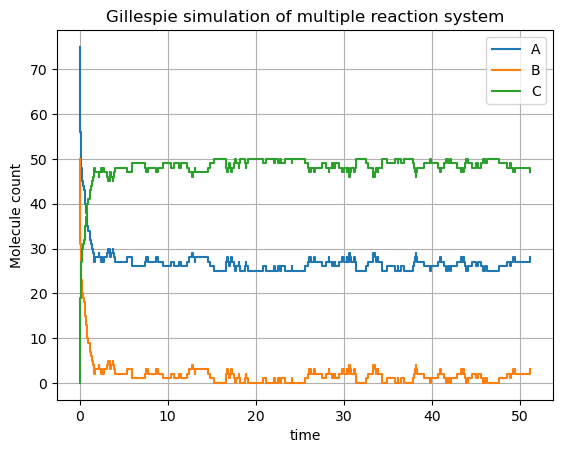

Final A: 28
Final B: 3
Final C: 47


In [31]:
# lets run a single reaction that is REVERSIBLE: i.e 2 reactions

# A + B -> C
# C -> A + B

new_SM = Matrix([[-1, -1, 1], [1,1,-1]]).T

# initial conditions
NA, NB, NC = 75, 50, 0                    # initial count of each species, this has input species as 100, output as 0, internals at 50 each
t, T = 0.0, 50.0                               # initial and final time
times, A_counts, B_counts, C_counts = [t], [NA], [NB], [NC]

I = [1,1]

# algorithm:

while t < T:

    propensity_vector = [0.04*NA*NB, 0.03*NC] # this reads as: probability rate for each reaction (rate * combinatorics_of_species)

    a0 = np.sum(propensity_vector)

    if a0 == 0:
        break

    r1, r2 = np.random.rand(2) # draw two random numbers - how random are they, use qiskit for quanutm randomness?

    tau = 1/a0 * np.log(1/r1)

    # Now need to select which reaction will occur using r2, prob is weighted by which is most likely to occur at the current state of the system:

    target_value = r2*a0

    cumulative = 0

    for n in range(len(propensity_vector)):

        cumulative += propensity_vector[n]

        if target_value <= cumulative:

            reaction_chosen = n

            break


    # perform updates

    t += tau

    stoich_vector = new_SM[:,reaction_chosen] # selects the reaction we will perform

        # population change depending on stoichiometric vector

    NA += stoich_vector[0,0]; NB += stoich_vector[1,0]; NC += stoich_vector[2,0]


    times.append(t); A_counts.append(NA); B_counts.append(NB); C_counts.append(NC) # sample counts at each point

plt.step(times, A_counts, where="post", label="A")
plt.step(times, B_counts, where="post", label="B")
plt.step(times, C_counts, where="post", label="C")

plt.xlabel("time"); plt.ylabel("Molecule count")
plt.grid(True)
plt.title("Gillespie simulation of multiple reaction system")
plt.legend(); plt.show()

print(r'Final A: {}'.format(A_counts[-1]))
print(r'Final B: {}'.format(B_counts[-1]))
print(r'Final C: {}'.format(C_counts[-1]))


In [ ]:
# deprecated code might still be useful

#propensity_vector = [kf_1*NA*ND,  kb_1*NB, kf_2*NB, kb_2*NA*NE, kf_3*NB*ND, kb_3*NC] # this reads as: probability rate for each reaction (rate * combinatorics_of_species)
    # propensity_vector = [kf_1*current_pops[0]*current_pops[3], kb_1*current_pops[1] \
    #                      , kf_2*current_pops[1], kb_2*current_pops[0]*current_pops[4] \
    #                      , kf_3*current_pops[1]*current_pops[4], kb_3*current_pops[2]]


#current_populations[0] += stoich_vector[0]; NB += stoich_vector[1]; NC += stoich_vector[2]
    
    # lets fix the chemostat species to see evolution of species inside, (comment out next line)
    #ND += stoich_vector[3,0]; NE += stoich_vector[4,0]


#A_counts.append(NA); B_counts.append(NB); C_counts.append(NC); D_counts.append(ND); E_counts.append(NE) # sample counts at each point

Matrix([
[-1,  1],
[-1,  1],
[ 1, -1]])